# Retail Strategy and Analytics
##### Experimentation and uplift testing, comparing trial and control stores

### Loading required libraries and datasets

In [3]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import t

In [4]:
df = pd.read_csv(r"QVI_data.csv")

In [5]:
df.head()

,LYLTY_CARD_NBR,DATE,STORE_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE,BRAND,LIFESTAGE,PREMIUM_CUSTOMER
0,1000,2018-10-17,1,1,5,Natural Chip Compny SeaSalt175g,2,6.0,175,NATURAL,YOUNG SINGLES/COUPLES,Premium
1,1002,2018-09-16,1,2,58,Red Rock Deli Chikn&Garlic Aioli 150g,1,2.7,150,RRD,YOUNG SINGLES/COUPLES,Mainstream
2,1003,2019-03-07,1,3,52,Grain Waves Sour Cream&Chives 210G,1,3.6,210,GRNWVES,YOUNG FAMILIES,Budget
3,1003,2019-03-08,1,4,106,Natural ChipCo Hony Soy Chckn175g,1,3.0,175,NATURAL,YOUNG FAMILIES,Budget
4,1004,2018-11-02,1,5,96,WW Original Stacked Chips 160g,1,1.9,160,WOOLWORTHS,OLDER SINGLES/COUPLES,Mainstream


In [6]:
df.shape

(264834, 12)

In [7]:
# Checking for duplicates
df.duplicated().sum()

1

In [8]:
df.drop_duplicates(inplace=True)

In [9]:
df.columns = df.columns.str.lower()

In [10]:
# Counting the number of dates of transactions
df['date'].nunique()

364

In [11]:
# Finding date range
print('Dateset ranges from', min(df['date']), 'to', max(df['date']))

Dateset ranges from 2018-07-01 to 2019-06-30


In [12]:
# Creating of sequence of dates
all_dates = pd.DataFrame({'date' : pd.date_range(start="2018-07-01", end="2019-06-30", freq='D')})

In [13]:
# Fixing data type
df['date'] = pd.to_datetime(df['date'])

In [14]:
# Joining the all_dates and df_transactions to fix missing date
final_df = pd.merge(df, all_dates, on='date', how='right').fillna(0)

In [15]:
# Examining the number of dates
df['date'].nunique()

364

## Select Control Stores

The client haas selected store numbers 77, 88, 88 as the trial stores and want control stores to be established stores that are operational for the entire observatiion period.

The control stores should match the trial stores such that they are similar to the trial store prior to the trial period of February 2019 in terms of:

- Monthly overall sales
- Monthly number of customers

### Understanding Test Stores

In [19]:
# Creating metrics that will help filter stores that are present throughout the pre-trial period

In [20]:
# Creating a month ID
final_df['year_month'] = final_df['date'].dt.year*100 + final_df['date'].dt.month

In [21]:
final_df['year_month']

0         201807
1         201807
2         201807
3         201807
4         201807
           ...  
264829    201906
264830    201906
264831    201906
264832    201906
264833    201906
Name: year_month, Length: 264834, dtype: int32

In [22]:
# Define the measure calculations
measure_over_time = (
    final_df.groupby(["store_nbr", "year_month"])
    .agg(
        total_sales=("tot_sales", "sum"),
        cust_cnt=("lylty_card_nbr", pd.Series.nunique),
        txn_cnt_per_cust=("txn_id", lambda x: x.nunique() / final_df.loc[x.index, "lylty_card_nbr"].nunique()),
        chips_per_txn=("txn_id", lambda x: final_df.loc[x.index, "prod_qty"].sum() / x.nunique() if x.nunique() != 0 else np.nan),
        avg_price_per_unit=("tot_sales", lambda x: x.sum() / final_df.loc[x.index, "prod_qty"].sum() if final_df.loc[x.index, "prod_qty"].sum() != 0 else np.nan),
    )
    .reset_index()
    .sort_values(by=["store_nbr", "year_month"])
)

In [23]:
measure_over_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3170 entries, 0 to 3169
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   store_nbr           3170 non-null   float64
 1   year_month          3170 non-null   int32  
 2   total_sales         3170 non-null   float64
 3   cust_cnt            3170 non-null   int64  
 4   txn_cnt_per_cust    3170 non-null   float64
 5   chips_per_txn       3170 non-null   float64
 6   avg_price_per_unit  3169 non-null   float64
dtypes: float64(5), int32(1), int64(1)
memory usage: 161.1 KB


In [24]:
# Finxing data type
measure_over_time['store_nbr'] = measure_over_time['store_nbr'].astype(int)

In [25]:
# Filling any null values with 0
measure_over_time = measure_over_time.fillna(0)

In [26]:
measure_over_time.head()

,store_nbr,year_month,total_sales,cust_cnt,txn_cnt_per_cust,chips_per_txn,avg_price_per_unit
0,0,201812,0.0,1,1.000000,0.000000,0.000000
1,1,201807,206.9,49,1.061224,1.192308,3.337097
2,1,201808,176.1,42,1.023810,1.255814,3.261111
3,1,201809,278.8,59,1.050847,1.209677,3.717333
4,1,201810,188.1,44,1.022727,1.288889,3.243103


In [27]:
# Filter to the stores with full obervation periods
stores_w_full_obs = measure_over_time.groupby('store_nbr').agg(month_cnt =('year_month', pd.Series.nunique)).reset_index()
stores_w_full_obs = stores_w_full_obs[stores_w_full_obs['month_cnt'] == 12]

In [28]:
# Filter to the pre-trial period
pre_trial_measures = measure_over_time[measure_over_time['year_month'] < 201902]
pre_trial_measures = pre_trial_measures[pre_trial_measures['store_nbr'].isin(stores_w_full_obs['store_nbr'])]

In [29]:
pre_trial_measures.head()

,store_nbr,year_month,total_sales,cust_cnt,txn_cnt_per_cust,chips_per_txn,avg_price_per_unit
1,1,201807,206.9,49,1.061224,1.192308,3.337097
2,1,201808,176.1,42,1.023810,1.255814,3.261111
3,1,201809,278.8,59,1.050847,1.209677,3.717333
4,1,201810,188.1,44,1.022727,1.288889,3.243103
5,1,201811,192.6,46,1.021739,1.212766,3.378947


In [30]:
# Creating a function to calculate correlation for a measure
def calculate_correlation(input_table, metric_col, store_comparison):
    # Creating an empty DataFrame to store results
    calc_corr_table = pd.DataFrame(columns=["Store1", "Store2", "corr_measure"])

    # Unique store numbers
    store_nbrs = input_table["store_nbr"].unique()

    # Looping through each store and calculate correlation
    for i in store_nbrs:
        # Extracting the metric values for the two stores
        store1_values = input_table.loc[input_table["store_nbr"] == store_comparison, metric_col]
        store2_values = input_table.loc[input_table["store_nbr"] == i, metric_col]

        # Computing correlation
        if len(store1_values) > 1 and len(store2_values) > 1:
            corr_measure = np.corrcoef(store1_values, store2_values)[0, 1]
        else:
            corr_measure = np.nan  

        # Appending the result to the DataFrame
        calc_corr_table = pd.concat(
            [calc_corr_table, pd.DataFrame({"Store1": [store_comparison], "Store2": [i], "corr_measure": [corr_measure]})],
            ignore_index=True
        )

    return calc_corr_table

In [31]:
# Creating a function to calcualte a standarised magnitude distance for a measure
def calculate_magnitude_distance(input_table, metric_col, store_comparison):
    # Creating an empty DataFrame
    calc_dist_table = pd.DataFrame(columns=["Store1", "Store2", "year_month", "measure"])

    # Unique store numbers
    store_nbrs = input_table["store_nbr"].unique()

    # Extracting the reference store's data
    reference_data = input_table[input_table["store_nbr"] == store_comparison][["year_month", metric_col]]

    # Looping through each store and calculate magnitude distance
    for i in store_nbrs:
        store_data = input_table[input_table["store_nbr"] == i][["year_month", metric_col]]

        # Merging both stores on year_month
        merged_data = reference_data.merge(store_data, on="year_month", suffixes=("_ref", "_comp"))

        # Computing absolute difference
        merged_data["measure"] = abs(merged_data[f"{metric_col}_ref"] - merged_data[f"{metric_col}_comp"])

        # Appending results
        merged_data["Store1"] = store_comparison
        merged_data["Store2"] = i
        calc_dist_table = pd.concat([calc_dist_table, merged_data[["Store1", "Store2", "year_month", "measure"]]])
    # Standardising the magnitude distance so that the measure ranges from 0 to 1
    min_max_dist = calc_dist_table.groupby(["Store1", "year_month"])["measure"].agg(["min", "max"]).reset_index()
    min_max_dist.rename(columns={"min": "minDist", "max": "maxDist"}, inplace=True)

    # Merging with the original table
    dist_table = calc_dist_table.merge(min_max_dist, on=["Store1", "year_month"], how="left")

    # Applying Min-Max normalization (handling division by zero)
    dist_table["magnitudeMeasure"] = 1 - (dist_table["measure"] - dist_table["minDist"]) / (dist_table["maxDist"] - dist_table["minDist"])
    dist_table["magnitudeMeasure"] = dist_table["magnitudeMeasure"].fillna(1)  # If min == max, set it to 1

    # Computing the mean magnitude measure for each Store1-Store2 pair
    final_dist_table = dist_table.groupby(["Store1", "Store2"])["magnitudeMeasure"].mean().reset_index()
    final_dist_table.rename(columns={"magnitudeMeasure": "mag_measure"}, inplace=True)
    return final_dist_table
    

Using the functions calculate_correlation and calculate_magnitude_distance to find control stores for trial stores.

The control stores are matched based on how similar **Monthly Total Sales** and **Monthly Number of Customers** are in the trial stores. So the functions will give overall 4 scores, two each for sales and customer count.

## Store 77

In [34]:
# Trial store
trial_stores = [77]

In [35]:
# Empty list to store control store results
control_stores = []

for trial_store in trial_stores:
    # Calculating Correlation
    corr_sales = calculate_correlation(pre_trial_measures, 'total_sales', trial_store)
    corr_cust = calculate_correlation(pre_trial_measures, 'cust_cnt', trial_store)

    # Calculating Magnitude
    magni_sales = calculate_magnitude_distance(pre_trial_measures, 'total_sales', trial_store)
    magni_cust = calculate_magnitude_distance(pre_trial_measures, 'cust_cnt', trial_store)

    # Merging correlation and magnitude data
    score_sales = pd.merge(corr_sales, magni_sales, on=['Store1', 'Store2'])
    score_cust = pd.merge(corr_cust, magni_cust, on=['Store1', 'Store2'])

    # Defining correlation weight
    corr_weight = 0.5

    # Computing the weighted score
    score_sales['score_sales'] = (score_sales["corr_measure"] * corr_weight) + (score_sales["mag_measure"] * (1 - corr_weight))
    score_cust["score_cust"] = (score_cust["corr_measure"] * corr_weight) + (score_cust["mag_measure"] * (1 - corr_weight))

    # Combining scores across the drivers
    score_control = pd.merge(score_sales, score_cust, on=['Store1', 'Store2'])
    score_control['final_control_score'] = score_control['score_sales'] * 0.5 + score_control['score_cust'] * 0.5 

    # Selecting control store for the current trial store
    control_store = score_control.nlargest(2, 'final_control_score').iloc[-1]['Store2']

    # Appending the result as a tuple (trial_store, control_store)
    control_stores.append((trial_store, control_store))

C:\Users\ANJALI\AppData\Local\Temp\ipykernel_14972\1703915262.py:22: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  calc_corr_table = pd.concat(
C:\Users\ANJALI\AppData\Local\Temp\ipykernel_14972\1703915262.py:22: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  calc_corr_table = pd.concat(
C:\Users\ANJALI\AppData\Local\Temp\ipykernel_14972\2877211559.py:25: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exc

All the scores calculated using the functions were combined to create a composite score to rank the store on. 
A simple average of the correlation and magnitude scores for each driver is taken.

If the trend of the drivers being similar is more important, then weight of the correlation score can be increased (a simple average gives a weight of 0.5 to the corr_weight) or if the absolute size of the drivers is more important, the weight of the correlatiion score can be lowered. 

In [37]:
# Converting to DataFrame for better representation
control_stores_df = pd.DataFrame(control_stores, columns=['Trial_Store', 'Control_Store'])
control_stores_df

,Trial_Store,Control_Store
0,77,233


### Visual Checks on Trends based on the Drivers
Now that the respective control store is found for the trial store, the drivers are checked whether they are indeed similar in the period before the trial.

#### Sales

In [40]:
past_sales = measure_over_time.copy()

In [41]:
# Categorizing stores
past_sales["store_type"] = past_sales["store_nbr"].apply(lambda x: "Trial" if x == trial_store else "Control" if x == control_store else "Otherstores")

In [42]:
# Aggregating total sales by year_month and store_type
past_sales = past_sales.groupby(['year_month', 'store_type'], as_index=False)['total_sales'].mean()

In [43]:
# Converting year_month to proper date format
past_sales['txn_month'] =  pd.to_datetime(past_sales["year_month"].astype(str), format="%Y%m")

In [44]:
# Filter for dates before March 2019
past_sales = past_sales[past_sales['year_month'] < 201903]

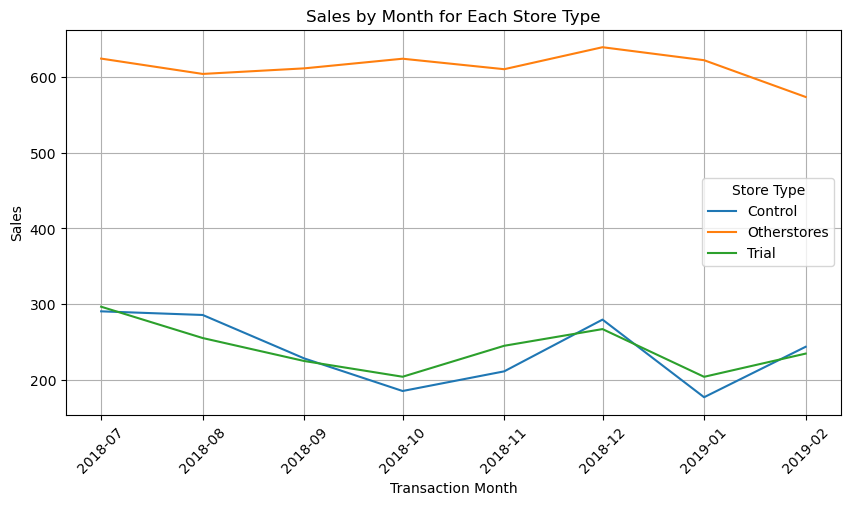

In [45]:
# Plot line chart
plt.figure(figsize=(10, 5))
for store in past_sales['store_type'].unique():
    subset = past_sales[past_sales['store_type'] == store]
    plt.plot(subset['txn_month'], subset['total_sales'], label=store)

plt.xlabel("Transaction Month")
plt.ylabel("Sales")
plt.title("Sales by Month for Each Store Type")
plt.legend(title="Store Type")
plt.xticks(rotation=45) 
plt.grid(True)
plt.show()

#### Customer Count

In [47]:
past_cust = measure_over_time.copy()

In [48]:
# Categorizing stores
past_cust["store_type"] = past_cust["store_nbr"].apply(lambda x: "Trial" if x == trial_store else "Control" if x == control_store else "Otherstores")

In [49]:
# Aggregating total sales by year_month and store_type
past_cust = past_cust.groupby(['year_month', 'store_type'], as_index=False)['cust_cnt'].mean()

In [50]:
# Converting year_month to proper date format
past_cust['txn_month'] =  pd.to_datetime(past_cust["year_month"].astype(str), format="%Y%m")

In [51]:
# Filter for dates before March 2019
past_cust = past_cust[past_cust['year_month'] < 201903]

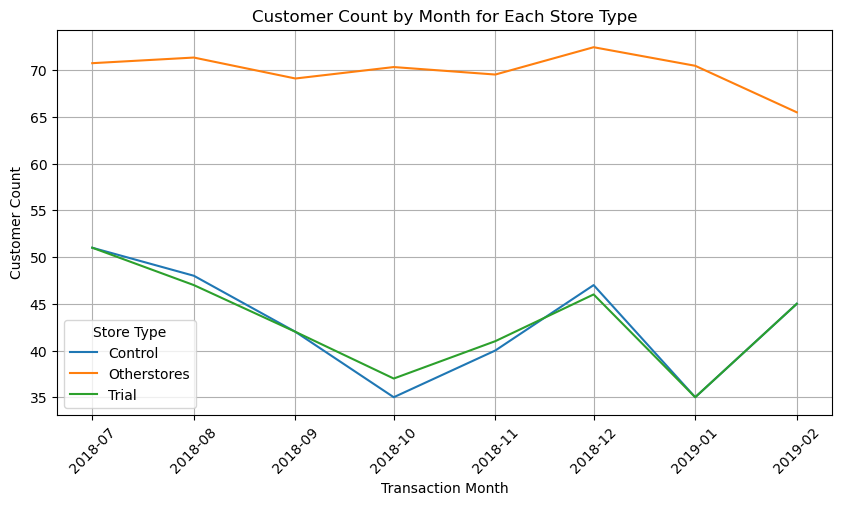

In [52]:
# Plot line chart
plt.figure(figsize=(10, 5))
for store in past_cust['store_type'].unique():
    subset = past_cust[past_cust['store_type'] == store]
    plt.plot(subset['txn_month'], subset['cust_cnt'], label=store)

plt.xlabel("Transaction Month")
plt.ylabel("Customer Count")
plt.title("Customer Count by Month for Each Store Type")
plt.legend(title="Store Type")
plt.xticks(rotation=45) 
plt.grid(True)
plt.show()

### Assesment Period
 The trial period starts from March 2019 till June 2019.
 Checking if there has been an uplift in overall chip sales. 

#### Sales of the store

The scaling the control store's sales to level similar to trial for any differences between the two stores outside the trial period. 

In [56]:
# Scaling pre-trial control sales to march pre-trial trial store sales
scaling_factor_for_control_sales = (pre_trial_measures.loc[(pre_trial_measures['store_nbr'] == trial_store) & 
                                    (pre_trial_measures['year_month'] < 201902), 'total_sales'].sum() / 
                                    pre_trial_measures.loc[(pre_trial_measures['store_nbr'] == control_store) & 
                                    (pre_trial_measures['year_month'] < 201902), 'total_sales'].sum())

In [57]:
measure_over_time_sales = measure_over_time.copy()

In [58]:
# Applying the scaling factor
measure_over_time_sales.loc[measure_over_time_sales['store_nbr'] == control_store, 'control_sales'] = measure_over_time_sales.loc[measure_over_time_sales['store_nbr'] == control_store, 'total_sales'] * scaling_factor_for_control_sales

In [59]:
# Filtering for the control store
scaled_control_sales = measure_over_time_sales[measure_over_time_sales['store_nbr'] == control_store]

Now the sales figures are comparable for the control stores, the percentage difference betweeen the scaled control store sales and the trial store's sales during the trial perid is calculated.

In [61]:
# Calculate the percentage difference between scaled control sales and trial sales
pcnt_diff = pd.merge(scaled_control_sales[['year_month', 'control_sales']], 
                     measure_over_time[measure_over_time['store_nbr'] == trial_store][['year_month', 'total_sales']], on='year_month')

In [62]:
pcnt_diff['pcnt_diff'] = abs(pcnt_diff['control_sales'] - pcnt_diff['total_sales']) / pcnt_diff['control_sales']

#### Null hypothesis
 H0: The sales during the trial period is the same as the sales during pre-trial period

In [64]:
# Finding the standard deviation for the pre-trial preiod
std_dev = np.std(pcnt_diff.loc[pcnt_diff['year_month'] < 201902, 'pcnt_diff'], ddof=1)
std_dev

0.04994076264142537

In [65]:
# Testing the null hypothesis i.e. there is 0 difference between trial and control stores
pcnt_diff['tValue'] = (pcnt_diff['pcnt_diff'] - 0) / std_dev

In [66]:
pcnt_diff['txn_month'] = pd.to_datetime(pcnt_diff['year_month'].astype(str), format='%Y%m')

In [67]:
result = pcnt_diff[(pcnt_diff['year_month'] < 201905) & (pcnt_diff['year_month'] > 201901)][['txn_month', 'tValue']]

In [68]:
result

,txn_month,tValue
7,2019-02-01,1.183534
8,2019-03-01,7.339116
9,2019-04-01,12.476373


In [69]:
# There are 8 months in the pre-trial period hence the degree of freedom is 8 - 1 
degrees_of_freedom = 7

# 95th percentile of t-distibution
t_critical = t.ppf(0.95, df=degrees_of_freedom)
print(t_critical)

1.894578605061305


The t-values is much larger than 95th percentile value of the t-distribution for March and April i.e. the increase in the sales in the trial store in March and April is statistically greater than in the control store. 

#### Visualizing 

In [72]:
measure_over_time_sales = measure_over_time.copy()

In [73]:
# Assigning Store Type: "Trial", "Control", or "Other Stores"
measure_over_time_sales['store_type'] = np.where(
    measure_over_time_sales['store_nbr'] == trial_store, "Trial",
    np.where(measure_over_time_sales['store_nbr'] == control_store, "Control", "OtherStores")
)

In [74]:
# Calculating mean total sales grouped by 'year_month' and 'store_type'
past_sales = measure_over_time_sales.groupby(['year_month', 'store_type'], as_index=False)['total_sales'].mean()

In [75]:
# Converting 'year_month' into a datetime format for visualization
past_sales['txn_month'] = pd.to_datetime(past_sales['year_month'].astype(str), format='%Y%m')

In [76]:
# Filtering only "Trial" and "Control" stores
past_sales = past_sales[past_sales['store_type'].isin(["Trial", "Control"])]

In [77]:
# **Calculate 95th and 5th percentiles for Control store**
# Control store 95th percentile: total sales * (1 + 2 * std_dev)
past_sales_95 = past_sales[past_sales['store_type'] == "Control"].copy()
past_sales_95['total_sales'] *= (1 + 2 * std_dev)
past_sales_95['store_type'] = "Control 95th% Confidence Interval"

In [78]:
# Control store 5th percentile: total sales * (1 - 2 * std_dev)
past_sales_5 = past_sales[past_sales['store_type'] == "Control"].copy()
past_sales_5['total_sales'] *= (1 - 2 * std_dev)
past_sales_5['store_type'] = "Control 5th% Confidence Interval"

In [79]:
# Combined datasets
trial_assessment = pd.concat([past_sales, past_sales_95, past_sales_5])

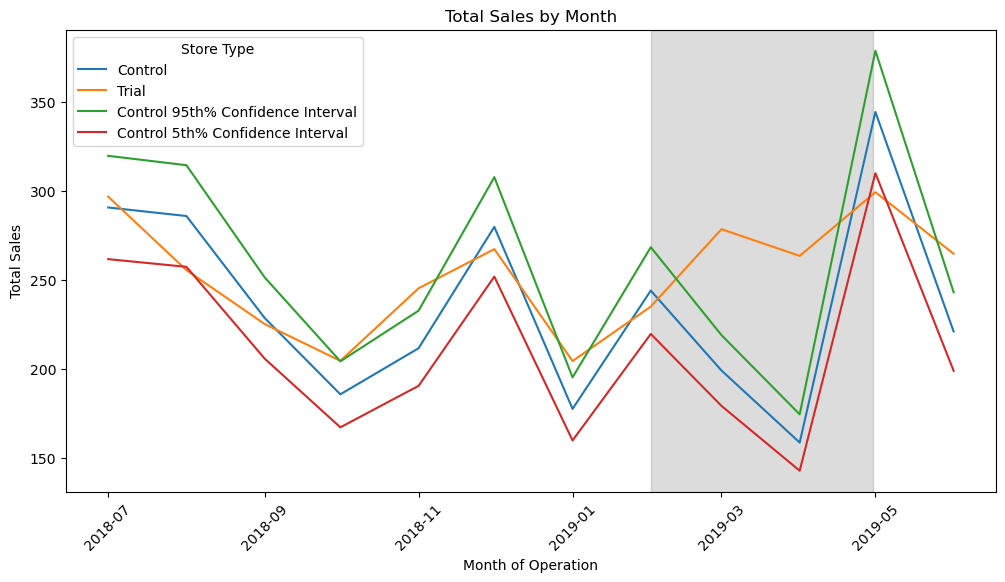

In [80]:
# Visualization
plt.figure(figsize=(12, 6))
sns.lineplot(data=trial_assessment, x="txn_month", y="total_sales", hue="store_type")

# Highlight the trial period (February 2019 - April 2019)
plt.axvspan(pd.to_datetime("2019-02-01"), pd.to_datetime("2019-04-30"), color='#505050', alpha=0.2)

# Labels and title
plt.xlabel("Month of Operation")
plt.ylabel("Total Sales")
plt.title("Total Sales by Month")
plt.legend(title="Store Type")
plt.xticks(rotation=45)
plt.show()

The results show that the trial in store 77 is significantly different to its control store in the trial period as the trial store performance lies outside the 5% to 95% confidence interval of the control store in two of the three trial months. 

#### Customer Count

The scaling the control store's sales to level similar to trial for any differences between the two stores outside the trial period. 

In [84]:
# Scaling pre-trial control customers to march pre-trial trial store customers
scaling_factor_for_control_cust = (pre_trial_measures.loc[(pre_trial_measures['store_nbr'] == trial_store) & 
                                    (pre_trial_measures['year_month'] < 201902), 'cust_cnt'].sum() / 
                                    pre_trial_measures.loc[(pre_trial_measures['store_nbr'] == control_store) & 
                                    (pre_trial_measures['year_month'] < 201902), 'cust_cnt'].sum())

In [85]:
measure_over_time_cust = measure_over_time.copy()

In [86]:
measure_over_time_cust.loc[measure_over_time_cust['store_nbr'] == control_store, 'control_cust'] = measure_over_time_cust.loc[measure_over_time_cust['store_nbr'] == control_store, 'cust_cnt'] * scaling_factor_for_control_cust

In [87]:
scaled_control_cust = measure_over_time_cust[measure_over_time_cust['store_nbr'] == control_store]

In [88]:
# Calculate the percentage difference between scaled control sales and trial customers
pcnt_diff_cust = pd.merge(scaled_control_cust[['year_month', 'control_cust']], 
                     measure_over_time[measure_over_time['store_nbr'] == trial_store][['year_month', 'cust_cnt']], on='year_month')

In [89]:
pcnt_diff_cust['pcnt_diff'] = abs(pcnt_diff_cust['control_cust'] - pcnt_diff_cust['cust_cnt']) / pcnt_diff_cust['control_cust']

#### Null hypothesis
H0 : The customer count during the trial period is the same as the customer count during pre-trial period

In [91]:
# Finding the standard deviation for the pre-trial preiod
std_dev = np.std(pcnt_diff_cust.loc[pcnt_diff_cust['year_month'] < 201902, 'pcnt_diff'], ddof=1)
std_dev

0.01824074855824395

In [92]:
# Testing the null hypothesis i.e. there is 0 difference between trial and control stores
pcnt_diff_cust['tValue'] = (pcnt_diff_cust['pcnt_diff'] - 0) / std_dev

In [93]:
pcnt_diff_cust['txn_month'] = pd.to_datetime(pcnt_diff_cust['year_month'].astype(str), format='%Y%m')

In [94]:
result_cust = pcnt_diff_cust[(pcnt_diff_cust['year_month'] < 201905) & (pcnt_diff_cust['year_month'] > 201901)][['txn_month', 'tValue']]

In [95]:
result_cust

,txn_month,tValue
7,2019-02-01,0.183352
8,2019-03-01,13.476388
9,2019-04-01,30.778725


The t-values is much larger than 95th percentile value of the t-distribution for March and April i.e. the increase in the customers in the trial store in March and April is statistically grater than in the control store. 

#### Visualizing

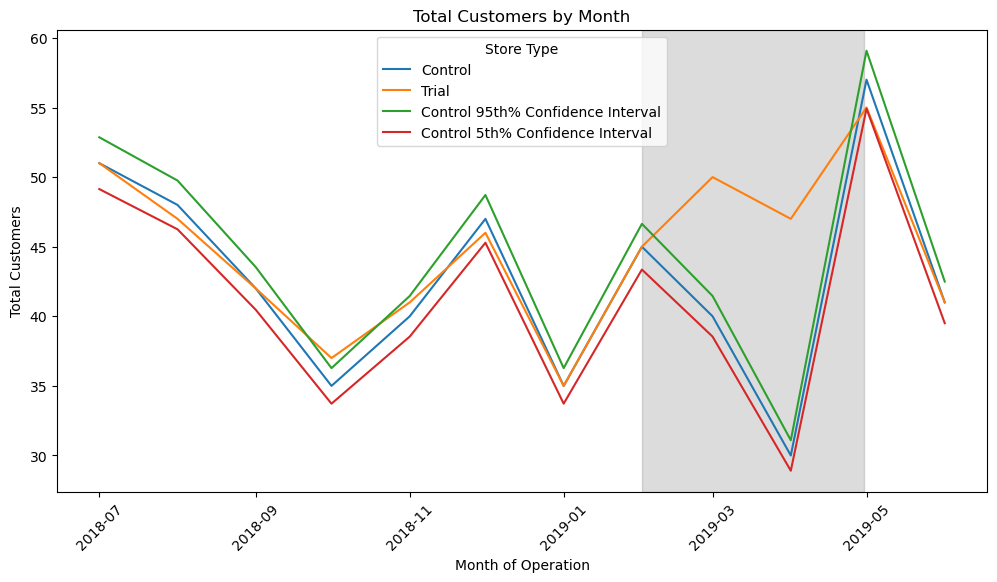

In [98]:
measure_over_time_cust = measure_over_time.copy()

# Assigning Store Type: "Trial", "Control", or "Other Stores"
measure_over_time_cust['store_type'] = np.where(
    measure_over_time_cust['store_nbr'] == trial_store, "Trial",
    np.where(measure_over_time_cust['store_nbr'] == control_store, "Control", "OtherStores")
)

# Calculating mean customer count grouped by 'year_month' and 'store_type'
past_cust = measure_over_time_cust.groupby(['year_month', 'store_type'], as_index=False)['cust_cnt'].mean()

# Converting 'year_month' into a datetime format for visualization
past_cust['txn_month'] = pd.to_datetime(past_cust['year_month'].astype(str), format='%Y%m')

# Filtering only "Trial" and "Control" stores
past_cust = past_cust[past_cust['store_type'].isin(["Trial", "Control"])]

# **Calculate 95th and 5th percentiles for Control store**
# Control store 95th percentile: customers count * (1 + 2 * std_dev)
past_cust_95 = past_cust[past_cust['store_type'] == "Control"].copy()
past_cust_95['cust_cnt'] *= (1 + 2 * std_dev)
past_cust_95['store_type'] = "Control 95th% Confidence Interval"

# Control store 5th percentile: customers count * (1 - 2 * std_dev)
past_cust_5 = past_cust[past_cust['store_type'] == "Control"].copy()
past_cust_5['cust_cnt'] *= (1 - 2 * std_dev)
past_cust_5['store_type'] = "Control 5th% Confidence Interval"

# Combined datasets
trial_assessment = pd.concat([past_cust, past_cust_95, past_cust_5])

# **Visualization**
plt.figure(figsize=(12, 6))
sns.lineplot(data=trial_assessment, x="txn_month", y="cust_cnt", hue="store_type")

# Highlight the trial period (February 2019 - April 2019)
plt.axvspan(pd.to_datetime("2019-02-01"), pd.to_datetime("2019-04-30"), color='#505050', alpha=0.2)

# Labels and title
plt.xlabel("Month of Operation")
plt.ylabel("Total Customers")
plt.title("Total Customers by Month")
plt.legend(title="Store Type")
plt.xticks(rotation=45)
plt.show()

## Store 86

In [100]:
# Trial Store
trial_stores = [86]

In [101]:
# Empty list to store control store results
control_stores = []

for trial_store in trial_stores:
    # Calculating Correlation
    corr_sales = calculate_correlation(pre_trial_measures, 'total_sales', trial_store)
    corr_cust = calculate_correlation(pre_trial_measures, 'cust_cnt', trial_store)

    # Calculating Magnitude
    magni_sales = calculate_magnitude_distance(pre_trial_measures, 'total_sales', trial_store)
    magni_cust = calculate_magnitude_distance(pre_trial_measures, 'cust_cnt', trial_store)

    # Merging correlation and magnitude data
    score_sales = pd.merge(corr_sales, magni_sales, on=['Store1', 'Store2'])
    score_cust = pd.merge(corr_cust, magni_cust, on=['Store1', 'Store2'])

    # Defining correlation weight
    corr_weight = 0.5

    # Computing the weighted score
    score_sales['score_sales'] = (score_sales["corr_measure"] * corr_weight) + (score_sales["mag_measure"] * (1 - corr_weight))
    score_cust["score_cust"] = (score_cust["corr_measure"] * corr_weight) + (score_cust["mag_measure"] * (1 - corr_weight))

    # Combining scores across the drivers
    score_control = pd.merge(score_sales, score_cust, on=['Store1', 'Store2'])
    score_control['final_control_score'] = score_control['score_sales'] * 0.5 + score_control['score_cust'] * 0.5 

    # Selecting control store for the current trial store
    control_store = score_control.nlargest(2, 'final_control_score').iloc[-1]['Store2']

    # Appending the result as a tuple (trial_store, control_store)
    control_stores.append((trial_store, control_store))

C:\Users\ANJALI\AppData\Local\Temp\ipykernel_14972\1703915262.py:22: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  calc_corr_table = pd.concat(
C:\Users\ANJALI\AppData\Local\Temp\ipykernel_14972\1703915262.py:22: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  calc_corr_table = pd.concat(
C:\Users\ANJALI\AppData\Local\Temp\ipykernel_14972\2877211559.py:25: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exc

In [102]:
# Converting to DataFrame for better representation
control_stores_df = pd.DataFrame(control_stores, columns=['Trial_Store', 'Control_Store'])
control_stores_df

,Trial_Store,Control_Store
0,86,155


### Visual Checks on Trends based on the Drivers

#### Sales

In [105]:
past_sales = measure_over_time.copy()

In [106]:
# Categorizing stores
past_sales["store_type"] = past_sales["store_nbr"].apply(lambda x: "Trial" if x == trial_store else "Control" if x == control_store else "Otherstores")

In [107]:
# Aggregating total sales by year_month and store_type
past_sales = past_sales.groupby(['year_month', 'store_type'], as_index=False)['total_sales'].mean()

In [108]:
# Converting year_month to proper date format
past_sales['txn_month'] =  pd.to_datetime(past_sales["year_month"].astype(str), format="%Y%m")

In [109]:
# Filter for dates before March 2019
past_sales = past_sales[past_sales['year_month'] < 201903]

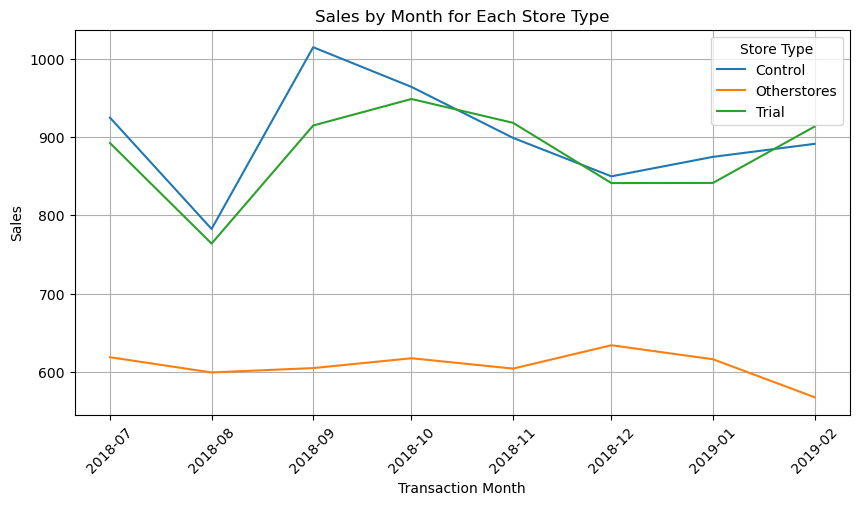

In [110]:
# Plot line chart
plt.figure(figsize=(10, 5))
for store in past_sales['store_type'].unique():
    subset = past_sales[past_sales['store_type'] == store]
    plt.plot(subset['txn_month'], subset['total_sales'], label=store)

plt.xlabel("Transaction Month")
plt.ylabel("Sales")
plt.title("Sales by Month for Each Store Type")
plt.legend(title="Store Type")
plt.xticks(rotation=45) 
plt.grid(True)
plt.show()

#### Customer Count

In [112]:
past_cust = measure_over_time.copy()

In [113]:
# Categorizing stores
past_cust["store_type"] = past_cust["store_nbr"].apply(lambda x: "Trial" if x == trial_store else "Control" if x == control_store else "Otherstores")

In [114]:
# Aggregating total sales by year_month and store_type
past_cust = past_cust.groupby(['year_month', 'store_type'], as_index=False)['cust_cnt'].mean()

In [115]:
# Converting year_month to proper date format
past_cust['txn_month'] =  pd.to_datetime(past_cust["year_month"].astype(str), format="%Y%m")

In [116]:
# Filter for dates before March 2019
past_cust = past_cust[past_cust['year_month'] < 201903]

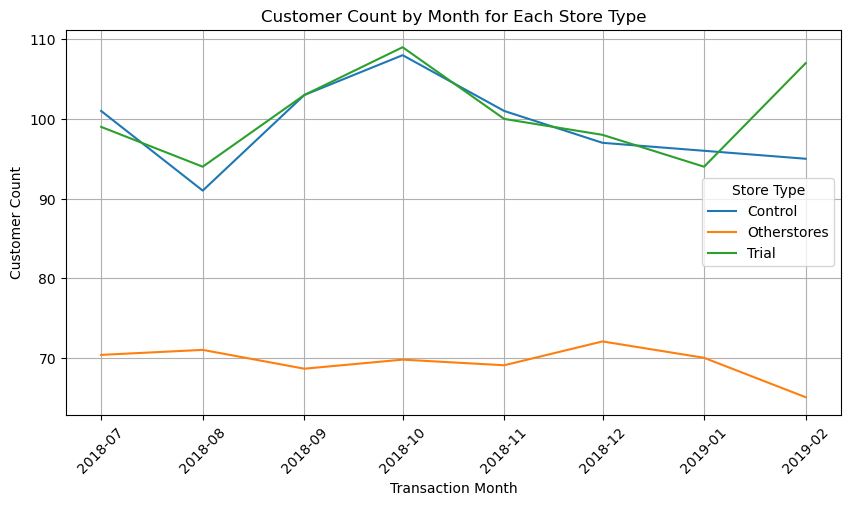

In [117]:
# Plot line chart
plt.figure(figsize=(10, 5))
for store in past_cust['store_type'].unique():
    subset = past_cust[past_cust['store_type'] == store]
    plt.plot(subset['txn_month'], subset['cust_cnt'], label=store)

plt.xlabel("Transaction Month")
plt.ylabel("Customer Count")
plt.title("Customer Count by Month for Each Store Type")
plt.legend(title="Store Type")
plt.xticks(rotation=45) 
plt.grid(True)
plt.show()

### Assesment Period
 March 2019 - June 2019

#### Sales of the store

In [120]:
# Scaling pre-trial control sales to march pre-trial trial store sales
scaling_factor_for_control_sales = (pre_trial_measures.loc[(pre_trial_measures['store_nbr'] == trial_store) & 
                                    (pre_trial_measures['year_month'] < 201902), 'total_sales'].sum() / 
                                    pre_trial_measures.loc[(pre_trial_measures['store_nbr'] == control_store) & 
                                    (pre_trial_measures['year_month'] < 201902), 'total_sales'].sum())

In [121]:
measure_over_time_sales = measure_over_time.copy()

In [122]:
# Applying the scaling factor
measure_over_time_sales.loc[measure_over_time_sales['store_nbr'] == control_store, 'control_sales'] = measure_over_time_sales.loc[measure_over_time_sales['store_nbr'] == control_store, 'total_sales'] * scaling_factor_for_control_sales

In [123]:
# Filtering for the control store
scaled_control_sales = measure_over_time_sales[measure_over_time_sales['store_nbr'] == control_store]

In [124]:
# Calculate the percentage difference between scaled control sales and trial sales
pcnt_diff = pd.merge(scaled_control_sales[['year_month', 'control_sales']], 
                     measure_over_time[measure_over_time['store_nbr'] == trial_store][['year_month', 'total_sales']], on='year_month')

In [125]:
pcnt_diff['pcnt_diff'] = abs(pcnt_diff['control_sales'] - pcnt_diff['total_sales']) / pcnt_diff['control_sales']

#### Null hypothesis
 H0: The sales during the trial period is the same as the sales during pre-trial period

In [127]:
# Finding the standard deviation for the pre-trial preiod
std_dev = np.std(pcnt_diff.loc[pcnt_diff['year_month'] < 201902, 'pcnt_diff'], ddof=1)
std_dev

0.025833952854772378

In [128]:
# Testing the null hypothesis i.e. there is 0 difference between trial and control stores
pcnt_diff['tValue'] = (pcnt_diff['pcnt_diff'] - 0) / std_dev

In [129]:
pcnt_diff['txn_month'] = pd.to_datetime(pcnt_diff['year_month'].astype(str), format='%Y%m')

In [130]:
result = pcnt_diff[(pcnt_diff['year_month'] < 201905) & (pcnt_diff['year_month'] > 201901)][['txn_month', 'tValue']]

In [131]:
result

,txn_month,tValue
7,2019-02-01,2.179542
8,2019-03-01,12.226922
9,2019-04-01,1.364580


In [132]:
# There are 8 months in the pre-trial period hence the degree of freedom is 8 -1 
degrees_of_freedom = 7

# 95th percentile of t-distibution
t_critical = t.ppf(0.95, df=degrees_of_freedom)
print(t_critical)

1.894578605061305


The t-values is much larger than 95th percentile value of the t-distribution for March i.e. the increase in the sales in the trial store in March is statistically grater than in the control store. 

#### Visualizing 

In [135]:
measure_over_time_sales = measure_over_time.copy()

In [136]:
# Assigning Store Type: "Trial", "Control", or "Other Stores"
measure_over_time_sales['store_type'] = np.where(
    measure_over_time_sales['store_nbr'] == trial_store, "Trial",
    np.where(measure_over_time_sales['store_nbr'] == control_store, "Control", "OtherStores")
)

In [137]:
# Calculating mean total sales grouped by 'year_month' and 'store_type'
past_sales = measure_over_time_sales.groupby(['year_month', 'store_type'], as_index=False)['total_sales'].mean()

In [138]:
# Converting 'year_month' into a datetime format for visualization
past_sales['txn_month'] = pd.to_datetime(past_sales['year_month'].astype(str), format='%Y%m')

In [139]:
# Filtering only "Trial" and "Control" stores
past_sales = past_sales[past_sales['store_type'].isin(["Trial", "Control"])]

In [140]:
# **Calculate 95th and 5th percentiles for Control store**
# Control store 95th percentile: total sales * (1 + 2 * std_dev)
past_sales_95 = past_sales[past_sales['store_type'] == "Control"].copy()
past_sales_95['total_sales'] *= (1 + 2 * std_dev)
past_sales_95['store_type'] = "Control 95th% Confidence Interval"

In [141]:
# Control store 5th percentile: total sales * (1 - 2 * std_dev)
past_sales_5 = past_sales[past_sales['store_type'] == "Control"].copy()
past_sales_5['total_sales'] *= (1 - 2 * std_dev)
past_sales_5['store_type'] = "Control 5th% Confidence Interval"

In [142]:
# Combined datasets
trial_assessment = pd.concat([past_sales, past_sales_95, past_sales_5])

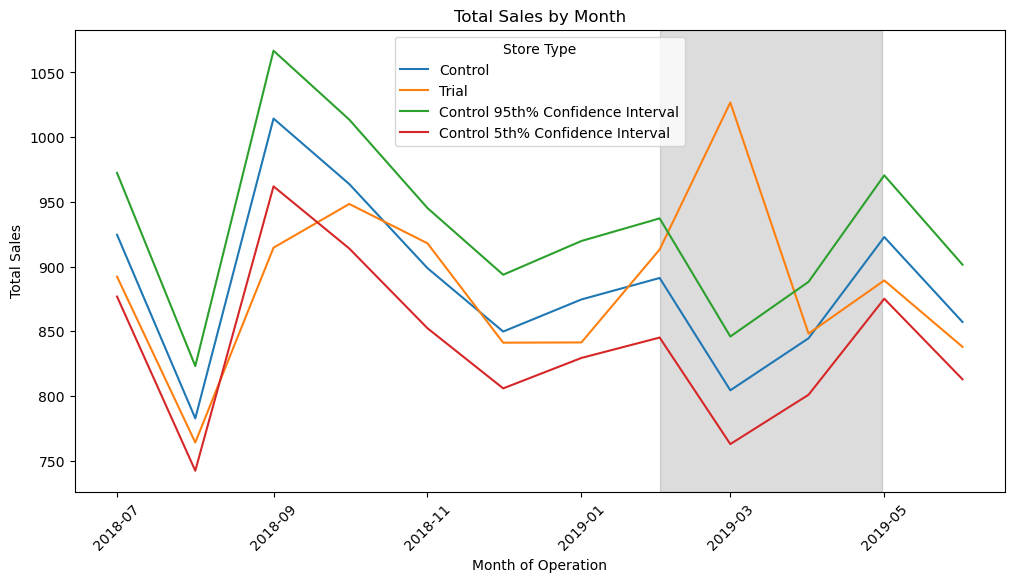

In [252]:
# Visualization
plt.figure(figsize=(12, 6))
sns.lineplot(data=trial_assessment, x="txn_month", y="total_sales", hue="store_type")

# Highlight the trial period (February 2019 - April 2019)
plt.axvspan(pd.to_datetime("2019-02-01"), pd.to_datetime("2019-04-30"), color='#505050', alpha=0.2)

# Labels and title
plt.xlabel("Month of Operation")
plt.ylabel("Total Sales")
plt.title("Total Sales by Month")
plt.legend(title="Store Type")
plt.xticks(rotation=45)
plt.show()

The results show that the trial in store 86 is not significantly different to its control store in the trial period as the trial store performance lies inside the 5% to 95% confidence interval of the control store in two of the three trial months.

#### Customer Count

In [312]:
# Scaling pre-trial control customers to march pre-trial trial store customers
scaling_factor_for_control_cust = (pre_trial_measures.loc[(pre_trial_measures['store_nbr'] == trial_store) & 
                                    (pre_trial_measures['year_month'] < 201902), 'cust_cnt'].sum() / 
                                    pre_trial_measures.loc[(pre_trial_measures['store_nbr'] == control_store) & 
                                    (pre_trial_measures['year_month'] < 201902), 'cust_cnt'].sum())

In [314]:
measure_over_time_cust = measure_over_time.copy()

In [316]:
# Applying the scaling factor
measure_over_time_cust.loc[measure_over_time_cust['store_nbr'] == control_store, 'control_cust'] = measure_over_time_cust.loc[measure_over_time_cust['store_nbr'] == control_store, 'cust_cnt'] * scaling_factor_for_control_cust

In [318]:
# Filtering for the control store
scaled_control_cust = measure_over_time_cust[measure_over_time_cust['store_nbr'] == control_store]

In [320]:
# Calculate the percentage difference between scaled control sales and trial customers
pcnt_diff_cust = pd.merge(scaled_control_cust[['year_month', 'control_cust']], 
                     measure_over_time[measure_over_time['store_nbr'] == trial_store][['year_month', 'cust_cnt']], on='year_month')

In [322]:
pcnt_diff_cust['pcnt_diff'] = abs(pcnt_diff_cust['control_cust'] - pcnt_diff_cust['cust_cnt']) / pcnt_diff_cust['control_cust']

#### Null hypothesis
H0 : The customer count during the trial period is the same as the customer count during pre-trial period

In [325]:
# Finding the standard deviation for the pre-trial preiod
std_dev = np.std(pcnt_diff_cust.loc[pcnt_diff_cust['year_month'] < 201902, 'pcnt_diff'], ddof=1)
std_dev

0.010687444701395238

In [327]:
# Testing the null hypothesis i.e. there is 0 difference between trial and control stores
pcnt_diff_cust['tValue'] = (pcnt_diff_cust['pcnt_diff'] - 0) / std_dev

In [329]:
pcnt_diff_cust['txn_month'] = pd.to_datetime(pcnt_diff_cust['year_month'].astype(str), format='%Y%m')

In [331]:
result_cust = pcnt_diff_cust[(pcnt_diff_cust['year_month'] < 201905) & (pcnt_diff_cust['year_month'] > 201901)][['txn_month', 'tValue']]

In [333]:
result_cust

,txn_month,tValue
7,2019-02-01,11.819082
8,2019-03-01,20.903430
9,2019-04-01,5.670772


It looks like the number of customers is significantly higher in all of the three months. This seems to suggest that the trial had a significant impact on increasing the number of customers in trial store 86 but as we saw, sales were not significantly higher. We should check with the Category Manager if there were special deals in the trial store that were may have resulted in lower prices, impacting the results.

#### Visualizing

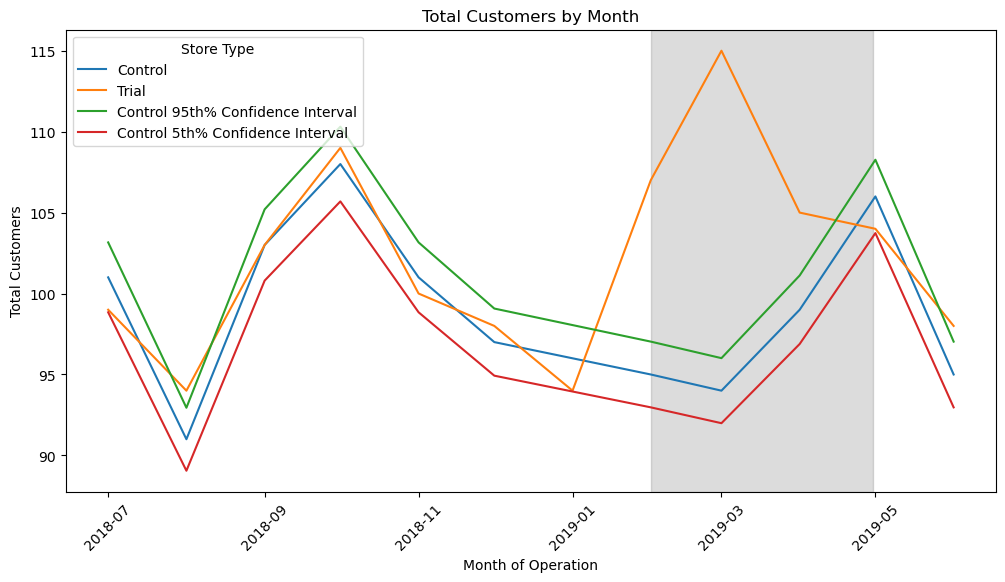

In [337]:
measure_over_time_cust = measure_over_time.copy()

# Assigning Store Type: "Trial", "Control", or "Other Stores"
measure_over_time_cust['store_type'] = np.where(
    measure_over_time_cust['store_nbr'] == trial_store, "Trial",
    np.where(measure_over_time_cust['store_nbr'] == control_store, "Control", "OtherStores")
)

# Calculating mean customer count grouped by 'year_month' and 'store_type'
past_cust = measure_over_time_cust.groupby(['year_month', 'store_type'], as_index=False)['cust_cnt'].mean()

# Converting 'year_month' into a datetime format for visualization
past_cust['txn_month'] = pd.to_datetime(past_cust['year_month'].astype(str), format='%Y%m')

# Filtering only "Trial" and "Control" stores
past_cust = past_cust[past_cust['store_type'].isin(["Trial", "Control"])]

# **Calculate 95th and 5th percentiles for Control store**
# Control store 95th percentile: customers count * (1 + 2 * std_dev)
past_cust_95 = past_cust[past_cust['store_type'] == "Control"].copy()
past_cust_95['cust_cnt'] *= (1 + 2 * std_dev)
past_cust_95['store_type'] = "Control 95th% Confidence Interval"

# Control store 5th percentile: customers count * (1 - 2 * std_dev)
past_cust_5 = past_cust[past_cust['store_type'] == "Control"].copy()
past_cust_5['cust_cnt'] *= (1 - 2 * std_dev)
past_cust_5['store_type'] = "Control 5th% Confidence Interval"

# Combined datasets
trial_assessment = pd.concat([past_cust, past_cust_95, past_cust_5])

# **Visualization**
plt.figure(figsize=(12, 6))
sns.lineplot(data=trial_assessment, x="txn_month", y="cust_cnt", hue="store_type")

# Highlight the trial period (February 2019 - April 2019)
plt.axvspan(pd.to_datetime("2019-02-01"), pd.to_datetime("2019-04-30"), color='#505050', alpha=0.2)

# Labels and title
plt.xlabel("Month of Operation")
plt.ylabel("Total Customers")
plt.title("Total Customers by Month")
plt.legend(title="Store Type")
plt.xticks(rotation=45)
plt.show()

# Trial Store 88

In [340]:
# Trial stores
trial_stores = [88]

In [342]:
# Empty list to store control store results
control_stores = []

for trial_store in trial_stores:
    # Calculating Correlation
    corr_sales = calculate_correlation(pre_trial_measures, 'total_sales', trial_store)
    corr_cust = calculate_correlation(pre_trial_measures, 'cust_cnt', trial_store)

    # Calculating Magnitude
    magni_sales = calculate_magnitude_distance(pre_trial_measures, 'total_sales', trial_store)
    magni_cust = calculate_magnitude_distance(pre_trial_measures, 'cust_cnt', trial_store)

    # Merging correlation and magnitude data
    score_sales = pd.merge(corr_sales, magni_sales, on=['Store1', 'Store2'])
    score_cust = pd.merge(corr_cust, magni_cust, on=['Store1', 'Store2'])

    # Defining correlation weight
    corr_weight = 0.5

    # Computing the weighted score
    score_sales['score_sales'] = (score_sales["corr_measure"] * corr_weight) + (score_sales["mag_measure"] * (1 - corr_weight))
    score_cust["score_cust"] = (score_cust["corr_measure"] * corr_weight) + (score_cust["mag_measure"] * (1 - corr_weight))

    # Combining scores across the drivers
    score_control = pd.merge(score_sales, score_cust, on=['Store1', 'Store2'])
    score_control['final_control_score'] = score_control['score_sales'] * 0.5 + score_control['score_cust'] * 0.5 

    # Selecting control store for the current trial store
    control_store = score_control.nlargest(2, 'final_control_score').iloc[-1]['Store2']

    # Appending the result as a tuple (trial_store, control_store)
    control_stores.append((trial_store, control_store))

C:\Users\ANJALI\AppData\Local\Temp\ipykernel_1680\1703915262.py:22: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  calc_corr_table = pd.concat(
C:\Users\ANJALI\AppData\Local\Temp\ipykernel_1680\1703915262.py:22: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  calc_corr_table = pd.concat(
C:\Users\ANJALI\AppData\Local\Temp\ipykernel_1680\2877211559.py:25: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclud

In [344]:
# Converting to DataFrame for better representation
control_stores_df = pd.DataFrame(control_stores, columns=['Trial_Store', 'Control_Store'])
control_stores_df

,Trial_Store,Control_Store
0,88,237


In [346]:
past_sales = measure_over_time.copy()

In [348]:
# Categorizing stores
past_sales["store_type"] = past_sales["store_nbr"].apply(lambda x: "Trial" if x == trial_store else "Control" if x == control_store else "Otherstores")

In [350]:
# Aggregating total sales by year_month and store_type
past_sales = past_sales.groupby(['year_month', 'store_type'], as_index=False)['total_sales'].mean()

In [352]:
# Converting year_month to proper date format
past_sales['txn_month'] =  pd.to_datetime(past_sales["year_month"].astype(str), format="%Y%m")

In [354]:
# Filter for dates before March 2019
past_sales = past_sales[past_sales['year_month'] < 201903]

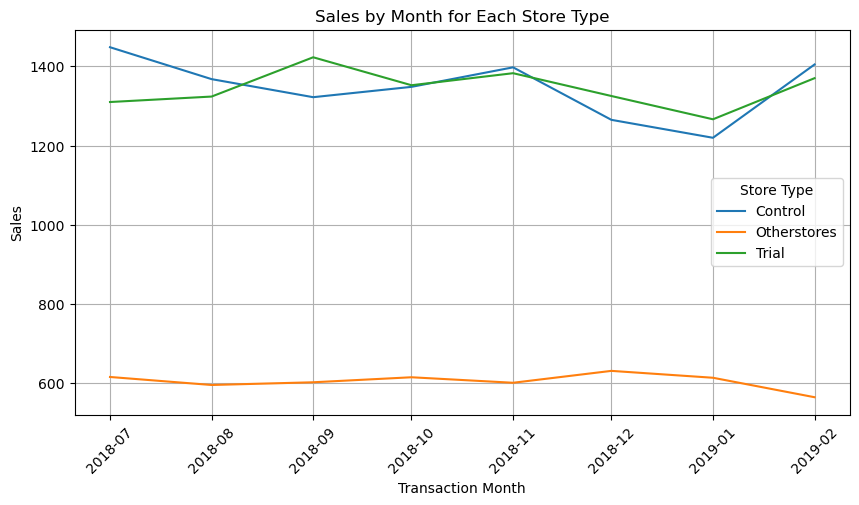

In [356]:
# Plot line chart
plt.figure(figsize=(10, 5))
for store in past_sales['store_type'].unique():
    subset = past_sales[past_sales['store_type'] == store]
    plt.plot(subset['txn_month'], subset['total_sales'], label=store)

plt.xlabel("Transaction Month")
plt.ylabel("Sales")
plt.title("Sales by Month for Each Store Type")
plt.legend(title="Store Type")
plt.xticks(rotation=45) 
plt.grid(True)
plt.show()

#### Customer Count

In [359]:
past_cust = measure_over_time.copy()

In [361]:
# Categorizing stores
past_cust["store_type"] = past_cust["store_nbr"].apply(lambda x: "Trial" if x == trial_store else "Control" if x == control_store else "Otherstores")

In [363]:
# Aggregating total sales by year_month and store_type
past_cust = past_cust.groupby(['year_month', 'store_type'], as_index=False)['cust_cnt'].mean()

In [365]:
# Converting year_month to proper date format
past_cust['txn_month'] =  pd.to_datetime(past_cust["year_month"].astype(str), format="%Y%m")

In [367]:
# Filter for dates before March 2019
past_cust = past_cust[past_cust['year_month'] < 201903]

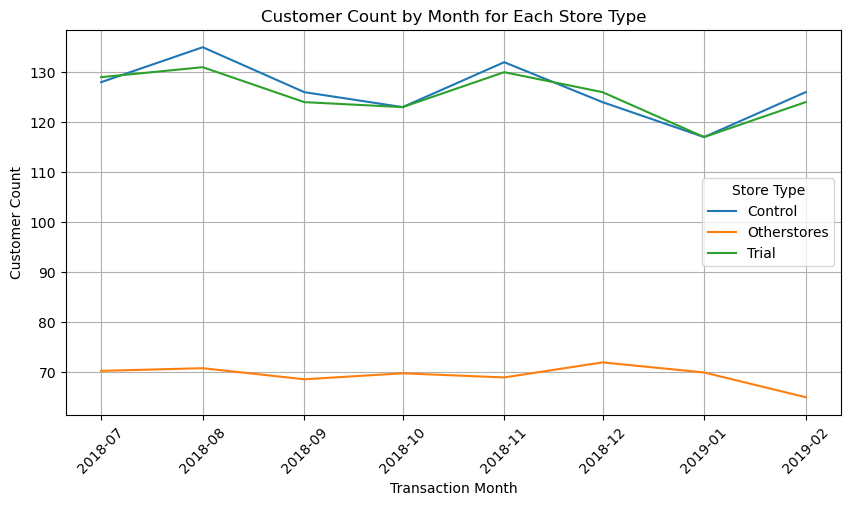

In [369]:
# Plot line chart
plt.figure(figsize=(10, 5))
for store in past_cust['store_type'].unique():
    subset = past_cust[past_cust['store_type'] == store]
    plt.plot(subset['txn_month'], subset['cust_cnt'], label=store)

plt.xlabel("Transaction Month")
plt.ylabel("Customer Count")
plt.title("Customer Count by Month for Each Store Type")
plt.legend(title="Store Type")
plt.xticks(rotation=45) 
plt.grid(True)
plt.show()

### Assesment Period
 March 2019 - June 2019

#### Sales of the store

In [384]:
# Scaling pre-trial control sales to march pre-trial trial store sales
scaling_factor_for_control_sales = (pre_trial_measures.loc[(pre_trial_measures['store_nbr'] == trial_store) & 
                                    (pre_trial_measures['year_month'] < 201902), 'total_sales'].sum() / 
                                    pre_trial_measures.loc[(pre_trial_measures['store_nbr'] == control_store) & 
                                    (pre_trial_measures['year_month'] < 201902), 'total_sales'].sum())

In [386]:
measure_over_time_sales = measure_over_time.copy()

In [388]:
# Applying the scaling factor
measure_over_time_sales.loc[measure_over_time_sales['store_nbr'] == control_store, 'control_sales'] = measure_over_time_sales.loc[measure_over_time_sales['store_nbr'] == control_store, 'total_sales'] * scaling_factor_for_control_sales

In [390]:
# Filtering for the control store
scaled_control_sales = measure_over_time_sales[measure_over_time_sales['store_nbr'] == control_store]

In [392]:
# Calculate the percentage difference between scaled control sales and trial sales
pcnt_diff = pd.merge(scaled_control_sales[['year_month', 'control_sales']], 
                     measure_over_time[measure_over_time['store_nbr'] == trial_store][['year_month', 'total_sales']], on='year_month')

In [394]:
pcnt_diff['pcnt_diff'] = abs(pcnt_diff['control_sales'] - pcnt_diff['total_sales']) / pcnt_diff['control_sales']

#### Null hypothesis
 H0: The sales during the trial period is the same as the sales during pre-trial period

In [397]:
# Finding the standard deviation for the pre-trial preiod
std_dev = np.std(pcnt_diff.loc[pcnt_diff['year_month'] < 201902, 'pcnt_diff'], ddof=1)
std_dev

0.0334678673030788

In [399]:
# Testing the null hypothesis i.e. there is 0 difference between trial and control stores
pcnt_diff['tValue'] = (pcnt_diff['pcnt_diff'] - 0) / std_dev

In [401]:
pcnt_diff['txn_month'] = pd.to_datetime(pcnt_diff['year_month'].astype(str), format='%Y%m')

In [403]:
result = pcnt_diff[(pcnt_diff['year_month'] < 201905) & (pcnt_diff['year_month'] > 201901)][['txn_month', 'tValue']]

In [405]:
result

,txn_month,tValue
7,2019-02-01,0.781270
8,2019-03-01,6.595668
9,2019-04-01,5.768527


In [407]:
# There are 8 months in the pre-trial period hence the degree of freedom is 8 -1 
degrees_of_freedom = 7

# 95th percentile of t-distibution
t_critical = t.ppf(0.95, df=degrees_of_freedom)
print(t_critical)

1.894578605061305


The t-values is much larger than 95th percentile value of the t-distribution for March and April i.e. the increase in the sales in the trial store in March and April is statistically grater than in the control store. 

#### Visualizing 

In [411]:
measure_over_time_sales = measure_over_time.copy()

In [413]:
# Assigning Store Type: "Trial", "Control", or "Other Stores"
measure_over_time_sales['store_type'] = np.where(
    measure_over_time_sales['store_nbr'] == trial_store, "Trial",
    np.where(measure_over_time_sales['store_nbr'] == control_store, "Control", "OtherStores")
)

In [415]:
# Calculating mean total sales grouped by 'year_month' and 'store_type'
past_sales = measure_over_time_sales.groupby(['year_month', 'store_type'], as_index=False)['total_sales'].mean()

In [417]:
# Converting 'year_month' into a datetime format for visualization
past_sales['txn_month'] = pd.to_datetime(past_sales['year_month'].astype(str), format='%Y%m')

In [419]:
# Filtering only "Trial" and "Control" stores
past_sales = past_sales[past_sales['store_type'].isin(["Trial", "Control"])]

In [421]:
# **Calculate 95th and 5th percentiles for Control store**
# Control store 95th percentile: total sales * (1 + 2 * std_dev)
past_sales_95 = past_sales[past_sales['store_type'] == "Control"].copy()
past_sales_95['total_sales'] *= (1 + 2 * std_dev)
past_sales_95['store_type'] = "Control 95th% Confidence Interval"

In [423]:
# Control store 5th percentile: total sales * (1 - 2 * std_dev)
past_sales_5 = past_sales[past_sales['store_type'] == "Control"].copy()
past_sales_5['total_sales'] *= (1 - 2 * std_dev)
past_sales_5['store_type'] = "Control 5th% Confidence Interval"

In [425]:
# Combined datasets
trial_assessment = pd.concat([past_sales, past_sales_95, past_sales_5])

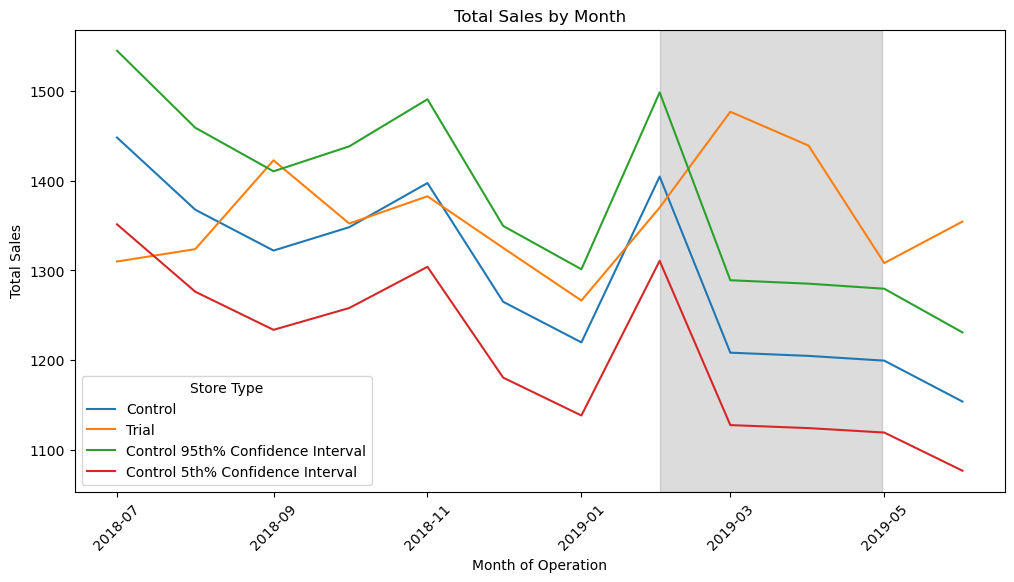

In [427]:
# Visualization
plt.figure(figsize=(12, 6))
sns.lineplot(data=trial_assessment, x="txn_month", y="total_sales", hue="store_type")

# Highlight the trial period (February 2019 - April 2019)
plt.axvspan(pd.to_datetime("2019-02-01"), pd.to_datetime("2019-04-30"), color='#505050', alpha=0.2)

# Labels and title
plt.xlabel("Month of Operation")
plt.ylabel("Total Sales")
plt.title("Total Sales by Month")
plt.legend(title="Store Type")
plt.xticks(rotation=45)
plt.show()

The results show that the trial in the store 88 is significantly different to its control store in the trial period as the trial store performance lies outside of the 5% to 95% confidence interval of the control store in two in the two of the three trial months. 

#### Customer Count

In [442]:
# Scaling pre-trial control customers to march pre-trial trial store customers
scaling_factor_for_control_cust = (pre_trial_measures.loc[(pre_trial_measures['store_nbr'] == trial_store) & 
                                    (pre_trial_measures['year_month'] < 201902), 'cust_cnt'].sum() / 
                                    pre_trial_measures.loc[(pre_trial_measures['store_nbr'] == control_store) & 
                                    (pre_trial_measures['year_month'] < 201902), 'cust_cnt'].sum())

In [444]:
measure_over_time_cust = measure_over_time.copy()

In [446]:
# Applying scaling factor
measure_over_time_cust.loc[measure_over_time_cust['store_nbr'] == control_store, 'control_cust'] = measure_over_time_cust.loc[measure_over_time_cust['store_nbr'] == control_store, 'cust_cnt'] * scaling_factor_for_control_cust

In [448]:
# Filtering for control store
scaled_control_cust = measure_over_time_cust[measure_over_time_cust['store_nbr'] == control_store]

In [450]:
# Calculate the percentage difference between scaled control sales and trial customers
pcnt_diff_cust = pd.merge(scaled_control_cust[['year_month', 'control_cust']], 
                     measure_over_time[measure_over_time['store_nbr'] == trial_store][['year_month', 'cust_cnt']], on='year_month')

In [452]:
pcnt_diff_cust['pcnt_diff'] = abs(pcnt_diff_cust['control_cust'] - pcnt_diff_cust['cust_cnt']) / pcnt_diff_cust['control_cust']

#### Null hypothesis
H0 : The customer count during the trial period is the same as the customer count during pre-trial period

In [455]:
# Finding the standard deviation for the pre-trial preiod
std_dev = np.std(pcnt_diff_cust.loc[pcnt_diff_cust['year_month'] < 201902, 'pcnt_diff'], ddof=1)
std_dev

0.00741024435207507

In [457]:
# Testing the null hypothesis i.e. there is 0 difference between trial and control stores
pcnt_diff_cust['tValue'] = (pcnt_diff_cust['pcnt_diff'] - 0) / std_dev

In [459]:
pcnt_diff_cust['txn_month'] = pd.to_datetime(pcnt_diff_cust['year_month'].astype(str), format='%Y%m')

In [461]:
result_cust = pcnt_diff_cust[(pcnt_diff_cust['year_month'] < 201905) & (pcnt_diff_cust['year_month'] > 201901)][['txn_month', 'tValue']]

In [463]:
result_cust

,txn_month,tValue
7,2019-02-01,1.387456
8,2019-03-01,17.873693
9,2019-04-01,9.814423


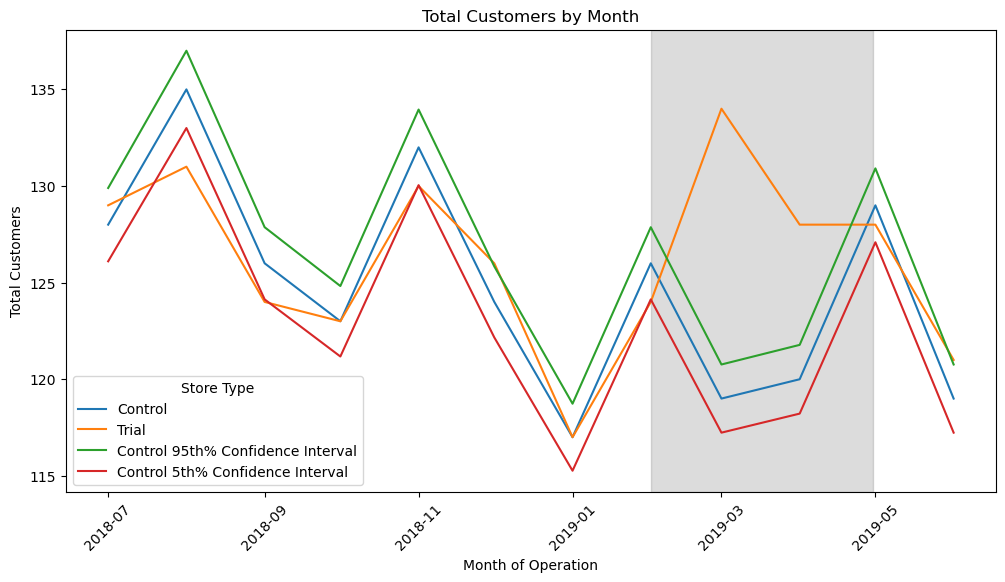

In [465]:
measure_over_time_cust = measure_over_time.copy()

# Assigning Store Type: "Trial", "Control", or "Other Stores"
measure_over_time_cust['store_type'] = np.where(
    measure_over_time_cust['store_nbr'] == trial_store, "Trial",
    np.where(measure_over_time_cust['store_nbr'] == control_store, "Control", "OtherStores")
)

# Calculating mean customer count grouped by 'year_month' and 'store_type'
past_cust = measure_over_time_cust.groupby(['year_month', 'store_type'], as_index=False)['cust_cnt'].mean()

# Converting 'year_month' into a datetime format for visualization
past_cust['txn_month'] = pd.to_datetime(past_cust['year_month'].astype(str), format='%Y%m')

# Filtering only "Trial" and "Control" stores
past_cust = past_cust[past_cust['store_type'].isin(["Trial", "Control"])]

# **Calculate 95th and 5th percentiles for Control store**
# Control store 95th percentile: customers count * (1 + 2 * std_dev)
past_cust_95 = past_cust[past_cust['store_type'] == "Control"].copy()
past_cust_95['cust_cnt'] *= (1 + 2 * std_dev)
past_cust_95['store_type'] = "Control 95th% Confidence Interval"

# Control store 5th percentile: customers count * (1 - 2 * std_dev)
past_cust_5 = past_cust[past_cust['store_type'] == "Control"].copy()
past_cust_5['cust_cnt'] *= (1 - 2 * std_dev)
past_cust_5['store_type'] = "Control 5th% Confidence Interval"

# Combined datasets
trial_assessment = pd.concat([past_cust, past_cust_95, past_cust_5])

# **Visualization**
plt.figure(figsize=(12, 6))
sns.lineplot(data=trial_assessment, x="txn_month", y="cust_cnt", hue="store_type")

# Highlight the trial period (February 2019 - April 2019)
plt.axvspan(pd.to_datetime("2019-02-01"), pd.to_datetime("2019-04-30"), color='#505050', alpha=0.2)

# Labels and title
plt.xlabel("Month of Operation")
plt.ylabel("Total Customers")
plt.title("Total Customers by Month")
plt.legend(title="Store Type")
plt.xticks(rotation=45)
plt.show()

Total number of customers in the trial period for the trial store is significantly higher that the control store for two out of three months, which indicates positice trial effect. 

## Conclusion
The trial store analysis provides clear evidence that the new store layout positively impacted both sales and customer count, particularly in March and April. 

Sales and customer footfall rose significantly in March and April across all trial stores, with Stores 77 and 88 showing the strongest uplift—signaling the new layout’s clear positive impact. February saw minimal change, indicating a short adjustment period for shoppers. Trial Store 86 showed a sharp sales spike in March, but this tapered off by April, although customer count remained consistently high—suggesting a disconnect between traffic and sales uplift. Store 88 also saw a modest decline in April, pointing to a gradual tapering of the layout’s influence. These patterns indicate that while the layout successfully drives short-term gains, sustaining momentum may require ongoing efforts like targeted promotions, refreshed product placement, or customer engagement initiatives.

The trial results strongly support rolling out the new layout to all stores, particularly in locations where customer behavior aligns with Trial Stores 77 and 88. However, further analysis is recommended to understand the sustainability of the impact and whether additional strategies, such as targeted promotions, can maintain sales growth over a longer period.